# Contains everything to run Ridge Regression Within-Subject

In [1]:
!pip install transformers

In [3]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import random
import math
import scipy.io as sio
import nibabel as nib
from scipy import signal
from pathlib import Path
from functools import reduce
# from google.colab import drive
import pandas as pd
import pickle
from PIL import Image
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import os
from gensim.models import KeyedVectors
import regex as re
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from statistics import stdev, mean

/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-12 00:12:29.270429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# drive.mount('/content/drive')
fMRI_folder = Path('../doi_10.5061_dryad.gt413__v1')

In [7]:
NUM_SUBJS = 8
subjects_fmri = [] #stores all 8 subject fmri np arrays

# fMRI_folder = Path('./doi_10.5061_dryad.gt413__v1')
# assert fMRI_folder.exists(), f"Foldder: {fMRI_folder} does not exist."

for subj_id in range(8):
    print("Subject:",subj_id)
#     fmri_file_name = str(subj_id) + '_masked_2d.npy'
#     fmri = np.load(fMRI_folder / fmri_file_name)
    fmri_file_name = str(subj_id) + '_smooth_nifti_4d.nii'
    fmri = nib.load(fMRI_folder / fmri_file_name)
    fmri = np.array(fmri.dataobj)
    assert isinstance(fmri, np.ndarray), f"Imported fmri_scan for subject {subj_id} is not of type numpy.ndarray"
    assert(fmri.ndim) == 4, f"Imported fmri_scan for subject {subj_id} is not 4 dimensional"
    subjects_fmri.append(fmri)


Subject: 0
Subject: 1
Subject: 2
Subject: 3
Subject: 4
Subject: 5
Subject: 6
Subject: 7


In [8]:
for x in subjects_fmri:
    print(np.shape(x))

(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)
(53, 60, 50, 1311)


In [9]:
mat_files = sorted(list(fMRI_folder.glob('subject_*.mat')))
sub_num = 0
matrices = []
for file in mat_files:
    mat_contents = sio.loadmat(file)
    matrix = np.zeros((np.shape(subjects_fmri[sub_num])[3],mat_contents["meta"][0][0][2][0][0],))
    fmri = subjects_fmri[int(str(file)[-5])-1]
    #print(np.shape(fmri))
    #print(mat_contents["meta"])

    print(mat_contents["meta"][0][0][3][0][0],mat_contents["meta"][0][0][4][0][0],mat_contents["meta"][0][0][5][0][0])
    for x in range(mat_contents["meta"][0][0][3][0][0]):
        for y in range(mat_contents["meta"][0][0][4][0][0]):
            for z in range(mat_contents["meta"][0][0][5][0][0]):
                col = mat_contents["meta"][0][0][7][x][y][z]
                matrix[:,col] = fmri[x-1][y-1][z-1][:]
    matrices.append(matrix)


53 60 50
51 60 49
53 59 47
53 59 44
51 59 45
49 56 51
52 60 49
52 60 48


In [10]:
feature_matrix = np.zeros((5176,195)) #stores the feature vectors as a row for each word
feature_names = [] #stores the names of all features in order
feature_types = {} #stores the types of features and all the names of the features for each type

features = sio.loadmat(fMRI_folder/'story_features.mat')
feature_count = 0
for feature_type in features['features'][0]:
    feature_types[feature_type[0][0]] = []
    if isinstance(feature_type[1][0], str):
        feature_types[feature_type[0][0]].append(feature_type[1][0])
        feature_names.append(feature_type[1][0])
    else:
        for feature in feature_type[1][0]:
            feature_types[feature_type[0][0]].append(feature[0])
            feature_names.append(feature[0])
    feature_matrix[:, feature_count:feature_count+feature_type[2].shape[1]] = feature_type[2] #adds the (5176xN) feature values to the feature matrix for the current feature group
    feature_count += feature_type[2].shape[1]

In [11]:
words_info = [] #stores tuples of (word, time, features) sorted by time appeared

mat_file = 'subject_1.mat' #only looks at the first subject file, somewhere it said all the timings were the same so this should be safe
mat_contents = sio.loadmat(fMRI_folder/mat_file)
# print(mat_content)
for count, row in enumerate(mat_contents['words'][0]):
    word_value = row[0][0][0][0]
    time = row[1][0][0]
    
    word_tuple = (word_value, time, feature_matrix[count,:])
    words_info.append(word_tuple)

In [12]:
chapter_nine_text = ""
for row in mat_contents['words'][0]:
    chapter_nine_text += row[0][0][0][0] + " "
# print(chapter_nine_text)

In [13]:
for count, subject in enumerate(subjects_fmri):
    print(count, np.shape(subject))

0 (53, 60, 50, 1311)
1 (53, 60, 50, 1311)
2 (53, 60, 50, 1311)
3 (53, 60, 50, 1311)
4 (53, 60, 50, 1311)
5 (53, 60, 50, 1311)
6 (53, 60, 50, 1311)
7 (53, 60, 50, 1311)


In [14]:
with open('fmri_indices', 'rb') as f:
    fmri_indices = pickle.load(f)

Harrison's implementation of Gaussian weighting

In [15]:
def hrf_alignment(num_words, words_info, NUM_SUBJS, subjects_fmri):

    subjects_samples = [[] for i in range(NUM_SUBJS)] #stores lists of all the samples for each subject
    window = signal.windows.gaussian(16, std=1) #gaussian window for the 4 fMRI scans
    num_words = num_words
    word_count = 0
    while word_count < len(words_info) - 24:
        #gets the 4 input words, and the 4 consecutive words while verifying they were read in sequence
        scan_words = []
        start_time = words_info[word_count][1]
        in_sequence = True #tracks if the words are in sequence or not
        for i in range(num_words):
            word_info = words_info[word_count + i]
            if word_info[1] != start_time + 0.5*i:
                #if some of the words are not in sequence, skip forward 1 word after innter loop
                in_sequence = False
            scan_words.append(word_info[0])
        if not in_sequence:
            word_count +=1
            continue
        fmri_time = start_time #fMRI is taken at first word read
        fmri_index = fmri_time//2 #since a scan happens every two seconds, the index is the time divided by 2
        if not np.issubdtype(fmri_index, np.integer):
            #if the first word is not aligned with the fmri scan (i.e. its not the first word in a TR)
            word_count += 1
            continue
        break_found = False
        for count, subject in enumerate(subjects_fmri):
#             print("Subject:",count)
            #adds tuple of (fmri_scan, four words)
            for i in range(num_words): #time delay of reading word after fMRI scan
                delay = 0.5*i #delay after first word
                for j in range(1,5): #get next 4 fMRI scans
                    fMRI_delay = 2*j - delay #delay until jth next fMRI scan
                    weight = window[int(2*fMRI_delay)-1] #gets the gaussian weighting (16 points instead of 8 to allow for .5)
                    try:
                        curr_fmri_idx = fmri_indices.index((start_time + math.floor(i/4) + 2*j)//2) #gets the index of the jth next fMRI scan
                    except:
#                         print("break found at index:",(start_time + math.floor(i/4) + 2*j)//2)
                        break_found = True
                        break
                    #adds weight fMRI scan
                    if j == 1:
                        word_scan = weight*subject[:][curr_fmri_idx]
                    else:
                        word_scan += weight*subject[:][curr_fmri_idx]
                if break_found:
                    break
                if i == 0:
                    summed_weighted_scans = word_scan
                else:
                    summed_weighted_scans += word_scan
            if break_found:
                break
            subjects_samples[count].append((summed_weighted_scans/num_words, scan_words))
        if break_found:
            word_count += 1
            continue 
#         print("Created sample:")
#         print("\tScan time:", str(start_time))
#         print("\tInput words:", str(scan_words))
        #if successful, skip forward to the next set of 4 words
        word_count += 4
    return subjects_samples

    print("Total number of samples:", str(len(subjects_samples[0])))

In [16]:
def get_fMRI_embedding(subjects_samples):
    scaler = StandardScaler()

    flattened_shape = reduce(np.multiply, subjects_samples[0][0].shape)
    X_matrix = np.zeros((len(subjects_samples), flattened_shape))

    for idx, sample in enumerate(subjects_samples):
        tmp = sample[0]
        # Reshape the voxels 
        tmp = tmp.ravel()
        X_matrix[idx,:] = tmp
        
    # Apply voxelwise standardization        
    X_matrix = scaler.fit_transform(X_matrix)
    #print(np.shape(X_matrix))
    return X_matrix

# Text encoders

In [17]:
# GloVe
glove_file = 'glove.840B.300d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

FileNotFoundError: [Errno 2] No such file or directory: 'glove.840B.300d.txt'

In [18]:
def remove_punctuation(word):
    return re.sub(r'[^\w\s]', '', word)

In [19]:
def get_embedding(word, model):
    oov = np.zeros((300))
    word = remove_punctuation(word)
    if word == "":
        word = "unk"
    if word in model.index_to_key:
        return model[word]
    else:
        return oov

In [20]:
def get_glove_embedding(subject_sample, model):

    hits = 0
    misses = 0
    embeddings = []
    embedding_matrix = np.zeros((len(subject_sample), 300))

    for count, sentence in enumerate(subject_sample):
        try:
            sentence_embedding = [get_embedding(word, glove_model) for word in sentence[1]]
            sentence_embedding = np.mean(sentence_embedding, axis=0)
            embedding_matrix[count,:] = sentence_embedding
        except ValueError:
            print(sentence[1])

    return embedding_matrix

In [21]:
# CLIP
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


KeyboardInterrupt: 

In [22]:
def get_SBERT_embedding(subject_sample):
    word_list = []
    context_length = 0

    for i in range(len(subject_sample)):
        context_length = len(subject_sample[i][1])
        word_list.append(subject_sample[i][1])
    new_word_list = [(' '.join(sublist)) for sublist in word_list]
    print(context_length)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    x = model.encode(new_word_list,convert_to_tensor=True)
    return x

In [ ]:
# USE DAN BASED
module_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
model_USE = hub.load(module_url)

In [ ]:
#USE TRANSFORMER BASED
module_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/large/versions/2"
model_USE = hub.load(module_url)

In [23]:
def get_USE_embedding(subject_sample):
    word_list = []
    context_length = 0

    for i in range(len(subject_sample)):
        context_length = len(subject_sample[i][1])
        word_list.append(subject_sample[i][1])
    new_word_list = [(' '.join(sublist)) for sublist in word_list]
    #print(new_word_list)
    #print(context_length)
    #model = hub.load(module_url)
    #print ("module %s loaded" % module_url)
    sentence_embeddings = model_USE(new_word_list)

    return np.array(sentence_embeddings)

In [24]:
def get_clip_embedding(subject_sample, model,processor):
    word_list = []
    for i in range(len(subject_sample)):
        word_list.append(subject_sample[i][1])
    new_word_list = [' '.join(sublist) for sublist in word_list]

    inputs = processor(text=new_word_list, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        # text_embeds is in the same space as the given image
        text_embeds = outputs['text_embeds']

        # pooler_output is just the text embedding 
        # This is what we want to use I think 
        pooler_output = outputs['text_model_output']['pooler_output']
#         print(pooler_output.numpy().shape)
    #return pooler_output
    return text_embeds

# Model Functions

In [25]:
# split data into train and test

def split_data(X_matrix, Y_matrix,random_seed):
    X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_matrix,
                                                        test_size=0.20,
                                                        random_state=random_seed,
                                                        shuffle=False)
    return X_train, X_test, y_train, y_test

In [26]:
# Train Ridge Regression Model

def train_model(X_train, y_train):
    
    ridge_model = Ridge(alpha=1.0)
    model = ridge_model.fit(X_train, y_train)
    
    return model


In [27]:
# Evaluate the model

def evaluate_model(model, X_test, y_test, random_text_embedding):
    correct_predictions = 0

    # Predict text embedding from test fMRI data
    y_pred = model.predict(X_test)
#     print(np.shape(y_pred))

    # Compute cosine similarity
    prediction_similarity_true = cosine_similarity(y_test, y_pred)
    prediction_similarity_random = cosine_similarity(random_text_embedding, y_pred)
#     print(np.shape(prediction_similarity_true), np.shape(prediction_similarity_true))
    
     # Count the occurrences of "1" in the first column    
    for i in range(X_test.shape[0]):
        if prediction_similarity_true[i].mean() >= prediction_similarity_random[i].mean():
            correct_predictions +=1

    # Calculate the accuracy
    accuracy = (correct_predictions / X_test.shape[0])
    
    return accuracy


In [28]:
def obtain_two_way_class_result(model, X_test, y_test, y_matrix, batches):
    accuracy = []
    for i in range(batches):
        idx = np.arange(len(y_test))
        np.random.shuffle(idx)

        random_text_embedding = y_matrix[idx]

        test_accuracy = evaluate_model(model, X_test, y_test, random_text_embedding)
        accuracy.append(test_accuracy)

    avg_accuracy = sum(accuracy)/ batches
    
    #print(accuracy)
    #print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
    
    return avg_accuracy

# Run Ridge Regression Within-Subject

In [30]:
random_seeds = [123,1234,122,1233,1235,1246,1232,1221,1542,1643,1231]
context_lengths = [4,8,12,16,20]
NUM_SUBJS = 8
text_encoding_name = "SBERT"
for length in context_lengths:
    # Step 1: Obtain aligned fMRI embedding with words
    print(f'Obtaining aligned fMRI scan for context length: {length}------------------------------------')
    subjects_samples = hrf_alignment(length, words_info, NUM_SUBJS, matrices)
    if text_encoding_name == 'glove':
        y_matrix = get_glove_embedding(subjects_samples[0],glove_model)
    elif text_encoding_name == 'clip':
        y_matrix = get_clip_embedding(subjects_samples[0],clip_model,clip_processor)
    elif text_encoding_name == 'USE':
        y_matrix = get_USE_embedding(subjects_samples[0])
    elif text_encoding_name == 'SBERT':
        y_matrix = get_SBERT_embedding(subjects_samples[0])
    
    # Step 2: Obtain text and fMRI embedding
    # get embeddings for subject 1
    accuracy_runs = []
    for x in range(10):
        print("run "+str(x))
        subjects_avg = []
        for subject in range(NUM_SUBJS):
            #print(f'---------Obtaining clip and fMRI embedding for subject {subject}-----------------')
            #y_matrix = get_clip_embedding(subjects_samples[subject],model,processor)
            X_matrix = get_fMRI_embedding(subjects_samples[subject])
            #print(f'Subject {subject} \n fMRI Embedding Shape: {np.shape(X_matrix)} \n Text Embedding Shape: {np.shape(y_matrix)}')

            # Split data for training
            #print(f'---------Spliting data for subject {subject}-----------------')
            X_train, X_test, y_train, y_test = split_data(X_matrix, y_matrix,random_seeds[x])        #print(f'---------Training started for subject {subject}-----------------')
            # Train model
            model_ = train_model(X_train, y_train)

            # Evaluate model
            #print(f'---------Getting two way classification accuracy for subject {subject}-----------------\n')

            batches = 8
            accuracy = obtain_two_way_class_result(model_, X_test, y_test, y_matrix, batches)

            print(f'{accuracy*100:.2f}')
            accuracy_runs.append(accuracy*100)
    print(mean(accuracy_runs),stdev(accuracy_runs))



Obtaining aligned fMRI scan for context length: 4------------------------------------
4
run 0
57.14
53.44
57.95
58.91
58.35
54.50
60.88
52.48
run 1
56.93
54.10
59.16
58.76
56.98
52.63
61.79
52.78
run 2
56.58
55.47
58.15
58.10
57.49
54.91
61.08
53.29
run 3
57.69
55.11
58.40
58.45
57.03
53.74
61.54
52.94
run 4
56.68
54.10
57.39
58.00
57.69
53.64
60.68
51.97
run 5
56.63
54.45
59.51
59.62
56.98
53.54
62.40
51.97
run 6
57.19
54.66
58.65
58.20
58.50
53.39
61.44
51.87
run 7
56.73
54.45
58.45
58.40
57.09
54.00
61.03
52.28
run 8
57.44
54.35
58.30
58.10
57.09
52.73
61.94
53.09
run 9
56.98
53.80
57.89
58.30
57.44
53.85
62.15
51.77
56.66940789473684 2.8556678570550544
Obtaining aligned fMRI scan for context length: 8------------------------------------


KeyboardInterrupt: 

# Get Figures

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


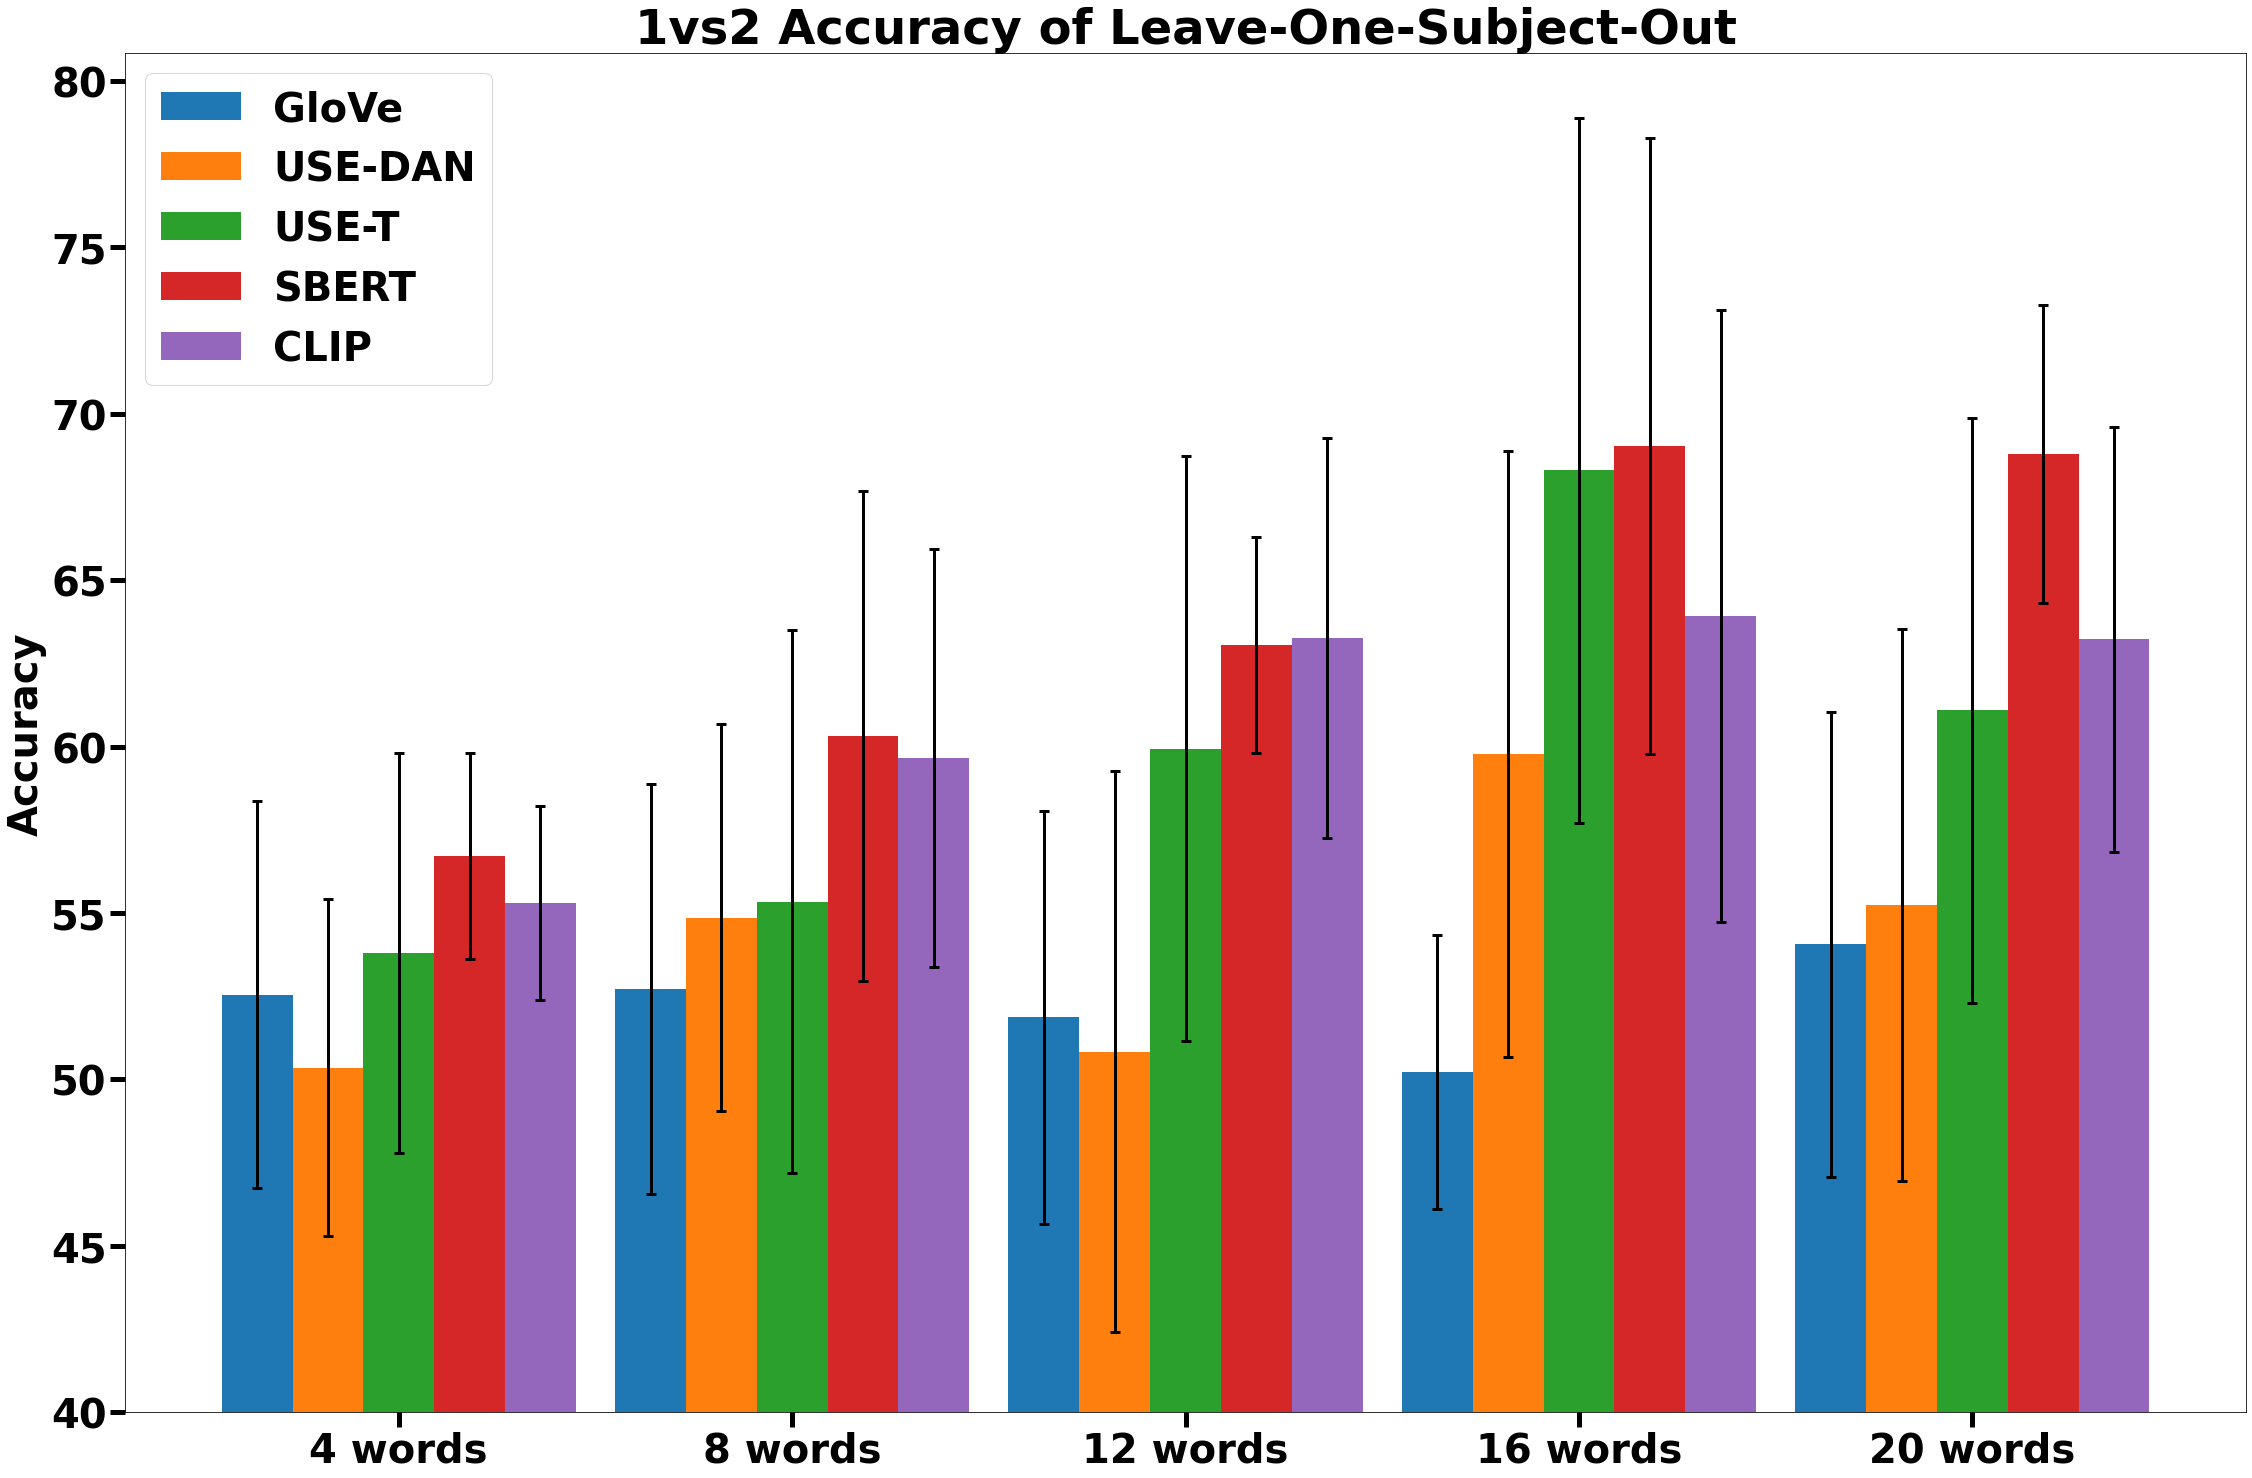

In [2]:

USE_DAN_means, USE_DAN_std = (50.36, 54.86, 50.84, 59.78, 55.24), (5.06, 5.81, 8.43, 9.1, 8.3)
USE_T_means, USE_T_std = (53.81, 55.34 , 59.94, 68.30, 61.10), (6.01, 8.16, 8.79, 10.59, 8.79)
CLIP_means, CLIP_std = (55.31, 59.67, 63.27, 63.93, 63.23), (2.92, 6.28, 6.00, 9.19, 6.39)
SBERT_means, SBERT_std = (56.72, 60.32, 63.05, 69.03, 68.79), (3.10, 7.36, 3.25, 9.26, 4.47)
GloVe_means, GloVe_std = (52.55, 52.71, 51.87, 50.22 , 54.06), (5.82, 6.16, 6.20, 4.11, 6.99)
offset = 40
ind = np.arange(len(USE_T_means))  # the x locations for the groups
width = 0.18  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width*2, [x-offset for x in GloVe_means], width, yerr=GloVe_std,
                label='GloVe', error_kw=dict(lw=3, capsize=5, capthick=3),bottom=offset)
rects2 = ax.bar(ind- width, [x-offset for x in USE_DAN_means], width, yerr=USE_DAN_std,
                label='USE-DAN', error_kw=dict(lw=3, capsize=5, capthick=3),bottom=offset)
rects3 = ax.bar(ind, [x-offset for x in USE_T_means], width, yerr=USE_T_std,
                label='USE-T', error_kw=dict(lw=3, capsize=5, capthick=3),bottom=offset)
rects4 = ax.bar(ind + width, [x-offset for x in SBERT_means], width, yerr=SBERT_std,
                label='SBERT', error_kw=dict(lw=3, capsize=5, capthick=3),bottom=offset)
rects5 = ax.bar(ind + width*2, [x-offset for x in CLIP_means], width, yerr=CLIP_std,
                label='CLIP', error_kw=dict(lw=3, capsize=5, capthick=3),bottom=offset)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy', weight='bold')
ax.set_title('1vs2 Accuracy of Leave-One-Subject-Out', weight='bold')
ax.set_xticks(ind)
ax.xaxis.set_tick_params(width=5,length=15)
ax.yaxis.set_tick_params(width=5,length=15)
ax.set_xticklabels(( '4 words','8 words', '12 words', '16 words','20 words'), weight='bold')
ax.legend()
plt.rcParams['figure.figsize'] = [38,25]
font = {'family': ["normal"],
        'weight' : 'bold',
        'size'   : 40}

plt.rc('font', **font)
#plt.yticks( size=50) 
#plt.rc('ytick', labelsize=50) 
#fig.tight_layout()

plt.show()